# 🦮 Multi-class Dog Breed Classification

This notebook builds a complete multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

To identify the breed of a dog with the image of a dog.

Example - taking a picture of a dog in a public space and determining its breed using this model.


## 2. Data

The data used in this project is from the [Kaggle's Dog Breed Indentification competition](https://www.kaggle.com/competitions/dog-breed-identification/data).

## 3. Evaluation

The evaluation is to predict a probability for each of the dog breeds ([see Kaggle website for details](https://www.kaggle.com/competitions/dog-breed-identification/overview)).

## 4. Features

Information about the data:
* We're dealing with images (unstructured data) - best to use deep learning and transfer learning
* There are 120 breads of dogs in the dataset (there are 120 different classes)
* There are ~10,000+ images in the training set (these images have labels)
* There are ~10,000+ images in the test set (these images do not have labels since we must predict them)

### Workspace Preparation

* Import TensorFlow 2.x✅
* Import TensorFlow Hub✅
* Make sure we are using a GPU✅

In [1]:
# Import basic tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import TensorFlow and TensorFlow Hub
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
# Check tensorflow and tensorflow-hub versions
print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

TF version: 2.15.0
TF Hub version: 0.15.0


In [4]:
# Check for GPU availability
print('GPU', 'available (Woohoo!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

GPU available (Woohoo!)


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Check number of GPU devices available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


2025-06-10 13:15:27.022114: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-10 13:15:27.022174: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-06-10 13:15:27.022190: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-06-10 13:15:27.022264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-10 13:15:27.022299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Test the speed of the GPU
import time

# Define matrix size
matrix_size = 4000

# Create matrices on GPU
a = tf.random.normal((matrix_size, matrix_size))
b = tf.random.normal((matrix_size, matrix_size))

# Perform matrix multiplication and measure time
start_time = time.time()
c = tf.matmul(a, b)
end_time = time.time()

print("Matrix multiplication time:", end_time - start_time, "seconds")

Matrix multiplication time: 0.003812074661254883 seconds


2025-06-10 13:15:31.236001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-10 13:15:31.236080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Getting our data ready (turning our images into Tensors)

Machine learning models need data to be in numerical format. Let's turn our images into numerical representations (Tensors).

We start by accessing our data and observing the labels.

In [8]:
# Check out the labels of our data
labels_csv = pd.read_csv('data/dog-breed-identification/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [9]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
# First ID of Kaggle matches our first ID in pandas and there are 10222 unique values in both Kaggle and our dataset✅
'000bec180eb18c7604dcecc8fe0dba07' == '000bec180eb18c7604dcecc8fe0dba07'

True

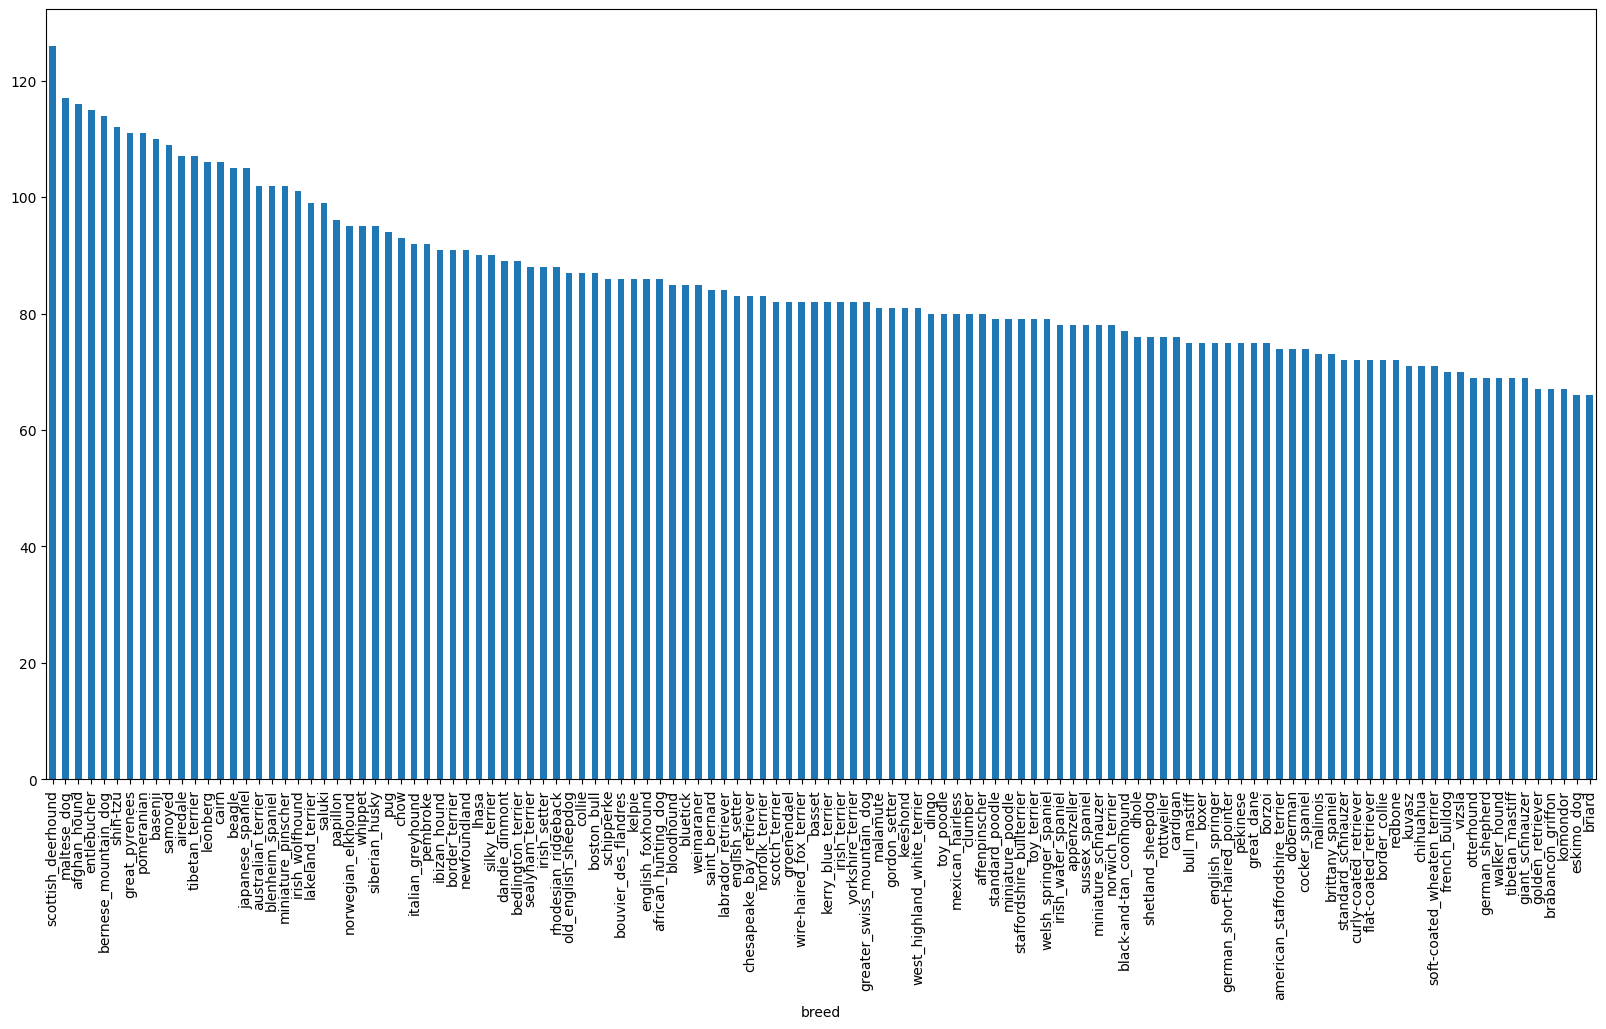

In [11]:
# How many images are there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize = (20,10));

In [12]:
# What is the median of number of images per dog breed? Important to determine if our model will be biased when learning.
# Google's minimum number of images per class is 10, and the recommended number per class is 100.
# Our dataset shows a median of 82.0. The datase is relatively well distributed, allowing our machine learning model to learn
# almost equally across all breeds.
labels_csv['breed'].value_counts().median()

82.0

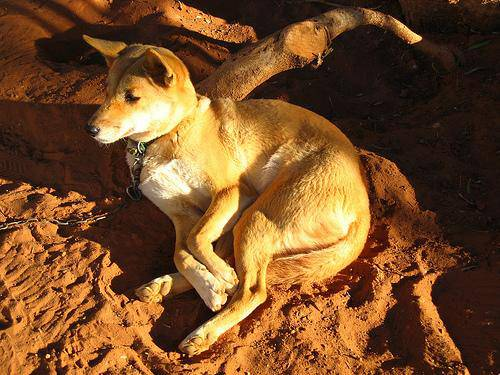

In [13]:
# Let's view an image
from IPython.display import Image
Image('data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all our image file paths and names.

In [14]:
# File names look like this:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [15]:
# Create path names from image IDs
filenames = ['data/dog-breed-identification/train/' + fname + '.jpg' for fname in labels_csv['id']]

# First 10 filenames
filenames[:10]

['data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [16]:
# Make sure the number of filenames in our list of paths + filenames equals those of the original data from Kaggle
len(filenames)

10222

In [17]:
# Number of paths/filenames from Kaggle equal to the list we created?
import os
if len(os.listdir('data/dog-breed-identification/train/')) == len(filenames):
    print('Filenames match actual amount of files from Kaggle dataset. We can proceed.')
else:
    print('Filenames do not match actual amount of files, check the target directory.')

Filenames match actual amount of files from Kaggle dataset. We can proceed.


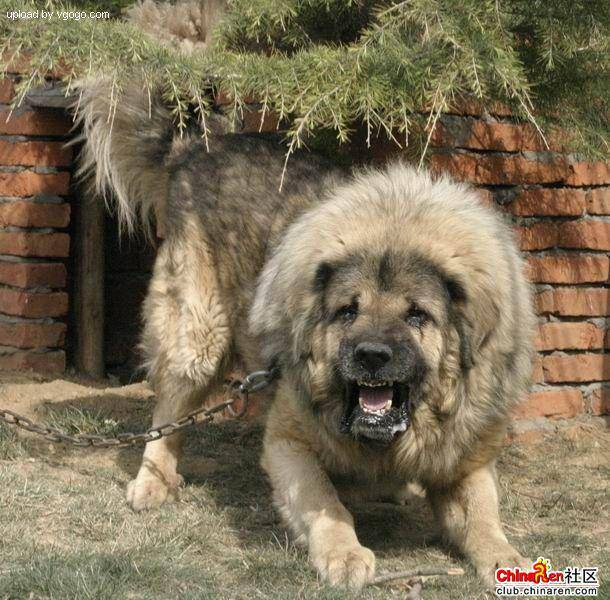

In [18]:
# Another check to verify our list of paths and filenames works correctly
Image(filenames[9000])

In [19]:
# Finding out what breed the image above is
labels_csv['breed'][9000]

'tibetan_mastiff'

With our training image file paths and names in a list, we can now prepare our labels (turn them into numbers).

In [20]:
breed_list = labels_csv['breed']
labels = np.array(breed_list)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [21]:
len(labels)

10222

In [22]:
# We can also transform the breed_list into a numpy array using pandas
breed_list = labels_csv['breed'].to_numpy()
labels = breed_list
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [23]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print('Number of labels matches number of filenames.')
else:
    print('Number of labels does not match number of filenames. Review data directories.')

Number of labels matches number of filenames.


In [24]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [25]:
len(unique_breeds)

120

In [26]:
# For a machine learning model to handle the breeds, we can make a boolean array based one the unique_breeds array
# for each item in the labels array that indicates what the breed (position of the True value in the boolean array
# based on unique_breeds)
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [27]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [28]:
len(boolean_labels)

10222

In [29]:
# Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [30]:
filenames[:10]

['data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

The Kaggle dataset does not come with a validation dataset. We need to create our own.

In [31]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [32]:
len(filenames)

10222

We'll start off experimenting with ~1000 images and increase as needed.

In [33]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 # In Colab you can you this function to create a slider
                  # to toggle the value of NUM_IMAGES instead of changing
                  # it in the code:
                  # @param {type:'slider', min: 1000, max: 10000, step: 1000}

In [34]:
# We'll split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split data into training and validation based on the total number of images in NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [35]:
# Let's look at the training data to make sure it is correct
X_train[:5], y_train[:2]

(['data/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'data/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'data/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, Fal

## Preprocessing Images (turning images into Tensors)

We will use a function to preprocess our images. The function will do the following things:
1. Take an image filename that includes its file path as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn the `image` (a jpg) into Tensors
4. 4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the`image` to be a shape of (224, 224)
6. Return the modified `image`

https://www.tensorflow.org/tutorials/load_data/images

Let's first import an image.

In [36]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [37]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [38]:
image.max(), image.min()

(255, 0)

In [39]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [40]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Using the above, let's make a function that:

1. Take an image filename that includes its file path as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn the `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the`image` to be a shape of (224, 224)
6. Return the modified `image`

... to preprocess our images.

In [41]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
    """
    Takes an image file path and name and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into a numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels = 3)
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the required size (224, 224)
    image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

    return image

## Turning our data into batches

Why batches?

When it comes to unstructured data of images, trying to process 10,000 + images in one step requires much more memory than we typically have access to.

~ 32 images at a time (32 is the batch size) is an optimal number to achieve great accuracy in pattern recognition while minimizing memory use and maintaining a high computing speed! This is similar to when we want to reduce noise in FTIR spectroscopy. Beyond 32 scans, the improvement of the singal-to-noise ratio reduces dramatically!

To use TensorFlow effectively, we need our data in the form of Tensor tuples. They look like this:
`(image, label)`.

In [42]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path and name and the associated label, processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [43]:
# Demo of the above code
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.32641783, 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.2389375 ],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247737],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now that we can turn our data into tuples of Tensors in the form, `(image, label)`, we'll make a function to turn all of our data (`X` and `y`) into batches.

In [44]:
# Define the batch size (32 is a good start)
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts tes data as input (no labels).
    """
    # If the data is a test dataset, we most likely don't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths and names (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths and names
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print('Creating training data batches...')
        # Turn filepaths with names and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames plus filenames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size = len(X))

        # Create (image, label) tuples (this also turns the image path with name into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
        
    return data_batch

In [45]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [46]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Data is now in batches. These batches can be difficult to understand/comprehend. We will now visualize them.

In [47]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    
    # Setup the figure
    plt.figure(figsize = (10, 10))
    
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Reduce font size of plot titles
        plt.rcParams.update({'font.size': 8})
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis('off')

In [48]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [49]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

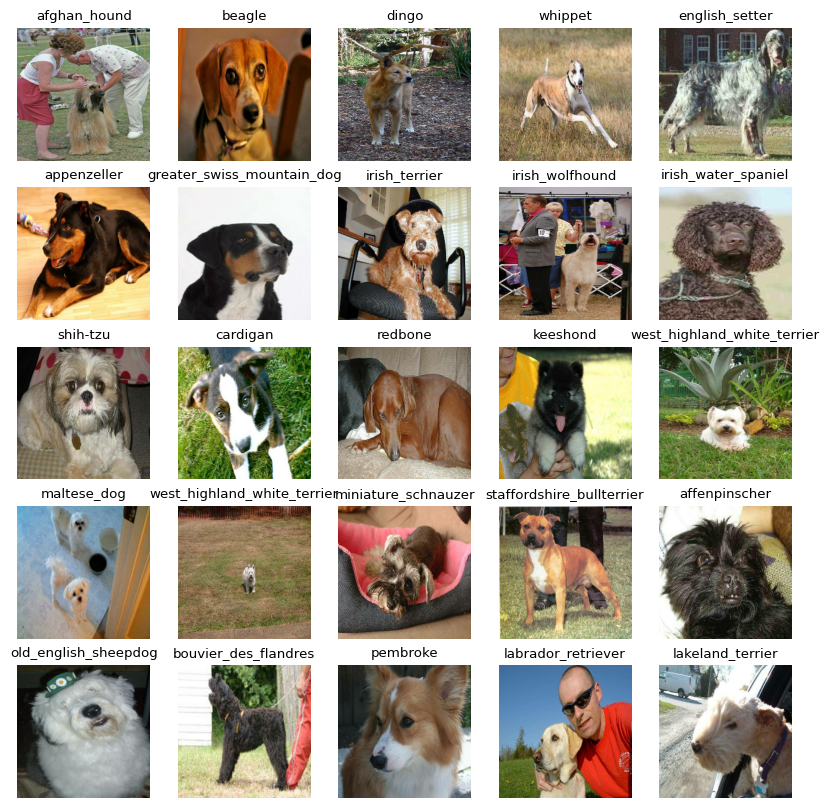

In [50]:
# Let's visualize the data in a training batch
show_25_images(train_images, train_labels)

In [51]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [52]:
# Let's visualize the data in a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
len(val_images), len(val_labels)

(32, 32)

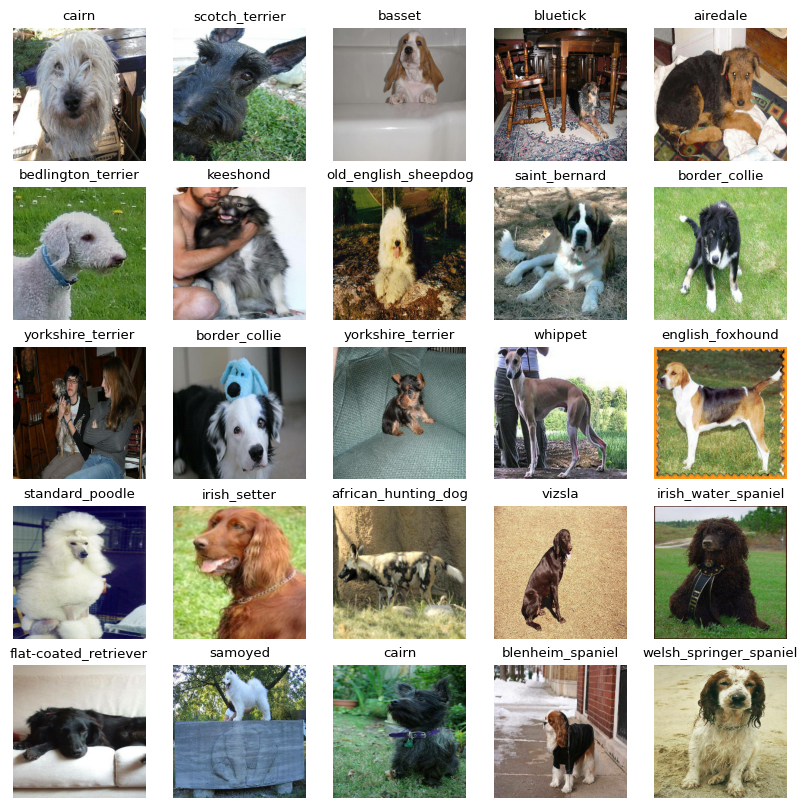

In [53]:
show_25_images(val_images, val_labels)

## Building a model

Before building a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification

Important resources for what goes on behind the scenes of a machine learning algorithm:

* [How Machines LEarn by GCP Grey on YouTube](https://www.youtube.com/watch?v=R9OHn5ZF4Uo)
* [deep learning series by 3Blue1Brown on YouyTube](https://www.youtube.com/watch?v=aircAruvnKk)

In [54]:
IMG_SIZE

224

In [55]:
# Setup input shape to our model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = 'https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2'

With our model selected and its inputs and outputs defined, we can use the TensorFlow Keras deep learning model API to build the model.

We'll create a function that:

* Takes the input shape, output shape and the model we've chosen as parameters
* Defines the layers in a Keras model in sequential fashion (i.e. do this first, then this, then that)
* Compiles the model (and indicates that it should be evaluated and improved)
* Builds the model (tells the model the input shape to expect)
* Returns the model

[See TensorFlow Keras documentation](https://www.tensorflow.org/guide/keras).

In [56]:
# Create a function that builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building model with:', MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
        tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                              activation = 'softmax') # Layer 2 (output layer)
    ])

    # Compile the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.legacy.Adam(), # instead of tf.keras.optimizers.Adam,
                                                       # use the legacy version which runs faster on apple M3
        metrics = ['accuracy']
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [57]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


**[MobileNetV2 Overall Architecture Resource](https://medium.com/codex/a-summary-of-the-mobilenetv2-inverted-residuals-and-linear-bottlenecks-paper-e19b187cb78a)**

In [58]:
# Output of MobileNetV2 is like this:
outputs = np.ones(shape = (1, 1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to save its progress, check its progress, or stop training early if a model stops improving.

**[See TensorFlow Keras Callbacks resource](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)**

Let's create two callbacks:

1. One for TensorBoard which helps track our models progress (verifies that loss function is reducing and accuracy is going up during training)
2. Another for early stopping which prevents our model from training for too long

### TensorBoard Callback

To setup a TensorBoard callback, we need to do three things:

1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function ✅
3. Visualize our model's training logs with the `%tensorboard` magic function (we'll do this after model training)

**[See TensorBoard Callback resource](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)**

In [59]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [60]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join('data/dog-breed-identification/logs',
                          # Have the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps prevent our model from overfitting by ending the training if a certain evaluation metric no longer improves.

**[See Early Stopping Callback resource](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)**

In [61]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',  # default monitor value is 'val_loss'
                                                  patience = 3)

## Training a model (on  a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working as expected.

In [62]:
NUM_EPOCHS = 100 # In Colab, a slider toggle to adjust this variable can be created with #@param {type: 'slider', min: 10, max: 100, step: 10}

In [63]:
# Check to make sure we are still running on a GPU
print('GPU', 'available (onward bound!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

GPU available (onward bound!)


Let's create a function that trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using our `create_tensorboard_callback()` function
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use
* Return the model

In [64]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session every time we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data, passing it the callback we created
    model.fit(x = train_data,
              epochs = NUM_EPOCHS,
              validation_data = val_data,
              validation_freq = 1,
              callbacks = [tensorboard, early_stopping])

    # Return the fitted model
    return model

In [65]:
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Epoch 1/100


2025-06-02 22:10:07.648272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 4s 97ms/step - loss: 4.5774 - accuracy: 0.1225 - val_loss: 3.4296 - val_accuracy: 0.2750
Epoch 2/100
25/25 [==============================] - 2s 84ms/step - loss: 1.6226 - accuracy: 0.6950 - val_loss: 2.2121 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 2s 84ms/step - loss: 0.5593 - accuracy: 0.9388 - val_loss: 1.7153 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 2s 84ms/step - loss: 0.2557 - accuracy: 0.9800 - val_loss: 1.5319 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 2s 84ms/step - loss: 0.1444 - accuracy: 0.9987 - val_loss: 1.4525 - val_accuracy: 0.6300
Epoch 6/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0989 - accuracy: 1.0000 - val_loss: 1.4082 - val_accuracy: 0.6450
Epoch 7/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 1.3835 - val_accuracy: 0.6650
Epoch 8/100
25/25 

**Question:** It looks like our model is overfitting because it's performing a lot better on the training dataset in comparison with the validation set. How can we prevent model overfitting in deep learning neural networks?

Increase training data:
1. Increasing the amount of data the model trains with
2. Diversify training data with data transformations (ex. rotations, flips, crops)

Regularization:
1. L1/L2 regularization - add a penalty to the loss function to discourage large weights
2. Dropout - randomly drop out neurons during training to force the model to learn more robust and redundant representations
3. Batch normalization - normalize the input to each layer of the neural network to improve training stability and reduce overfitting

Model simplification:
1. Reduce model complexity - reduce the number of layers, neurons per layers, or use simpler architectures to prevent the model from memorizing noise
2. Feature selection - identify and remove irrelevant or redundant features to simplify the input to the model

Training techniques:
1. Early stopping
2. Cross-validation
3. Hyperparameter tunning

Ensemble methods:
1. Combine different model to improve generalization

Other techniques:
1. Bias-variance tradeoff
2. Weight decay
3. Recursive feature elimination

**Note:** Overfitting is a good thing to begin with. It means our model is learning!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [66]:
%tensorboard --logdir data/dog-breed-identification/logs

## Making and evaluating predictions using a trained model

In [67]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [68]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 1s 72ms/step


array([[1.4639072e-03, 4.0750481e-05, 1.0741290e-03, ..., 5.7810568e-04,
        8.6413575e-06, 1.5697653e-03],
       [8.3845099e-03, 2.7646674e-04, 1.7191777e-02, ..., 2.2880589e-04,
        1.8502037e-03, 5.3952017e-04],
       [1.2311120e-06, 4.0117789e-05, 1.8942231e-06, ..., 1.1386409e-05,
        8.9746743e-07, 4.0926017e-05],
       ...,
       [7.6540991e-06, 6.0829425e-05, 1.7395923e-05, ..., 4.2547221e-05,
        1.2309731e-04, 1.3677629e-04],
       [2.5372982e-03, 4.1802030e-04, 1.4717807e-04, ..., 2.3683252e-04,
        1.2760230e-04, 7.3722685e-03],
       [1.0445691e-03, 5.0909759e-05, 8.2075223e-04, ..., 1.1612167e-02,
        1.5657394e-03, 2.4672903e-05]], dtype=float32)

In [69]:
predictions[0]

array([1.46390719e-03, 4.07504813e-05, 1.07412902e-03, 3.58322781e-04,
       6.56252028e-04, 5.59338150e-06, 2.78626271e-02, 5.54399798e-04,
       1.48918989e-04, 2.22391053e-03, 1.28071217e-04, 3.52667084e-05,
       6.01261738e-04, 2.85669612e-05, 2.45961361e-04, 1.31554974e-04,
       1.23366672e-05, 3.33249867e-01, 8.93051310e-06, 1.09116998e-04,
       1.09727937e-03, 3.43523498e-05, 2.31078338e-05, 5.63868962e-04,
       1.44068435e-05, 3.33633157e-04, 2.79280394e-01, 1.06184292e-04,
       3.00500018e-04, 9.13386248e-05, 1.53796296e-04, 2.66501098e-04,
       5.14449843e-04, 1.43395691e-05, 3.06481670e-05, 2.06484571e-02,
       8.53014571e-05, 2.25795739e-04, 2.43045506e-04, 2.92104989e-04,
       2.46491330e-03, 8.18011176e-05, 1.84778764e-05, 8.10136553e-05,
       4.20267243e-05, 5.47767086e-05, 1.26078503e-05, 4.00003919e-04,
       3.90519534e-04, 7.27092920e-05, 1.84290868e-04, 2.62767408e-05,
       6.15455443e-04, 2.35648782e-04, 4.24615828e-05, 2.70305645e-05,
      

In [70]:
np.sum(predictions[0])

1.0

In [71]:
np.sum(predictions[1])

1.0

In [72]:
len(predictions[0])

120

In [73]:
predictions.shape

(200, 120)

In [74]:
len(y_val)

200

In [75]:
len(unique_breeds)

120

In [76]:
# First prediction
index = 42
print(predictions[index])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_breeds[np.argmax(predictions[index])]}')

[7.93612708e-05 8.41665678e-05 1.57875620e-05 6.59932048e-05
 4.32388438e-03 1.22059144e-04 6.31264629e-05 4.01242432e-04
 1.20453537e-02 2.13930681e-02 1.69546147e-05 5.94151288e-06
 5.40540204e-04 1.09817157e-03 1.09158398e-03 1.02759257e-03
 3.54865988e-05 6.93999871e-04 4.71560634e-05 1.75150897e-04
 5.38032509e-05 3.47556517e-04 4.56306188e-05 9.49150854e-05
 6.62970077e-03 1.67914739e-04 1.06923972e-05 5.96328537e-05
 1.10072353e-04 2.62444246e-05 4.49658291e-05 1.15411734e-04
 5.36733824e-05 1.98701418e-05 3.31396623e-05 2.85281276e-05
 8.05341115e-05 2.80866312e-04 3.58635298e-05 1.35301620e-01
 6.18502265e-04 4.09325412e-06 3.89856729e-03 1.17699974e-05
 2.78184860e-04 1.55192483e-05 8.01640781e-05 6.49201858e-04
 5.09704587e-05 5.33826416e-04 4.06595173e-05 9.23331681e-05
 1.16978146e-04 5.95841382e-04 1.05118506e-05 4.32539789e-04
 1.06142388e-05 2.87933381e-05 1.16848583e-04 1.22101465e-05
 5.90180389e-05 1.27825432e-03 3.06535480e-06 1.15747744e-05
 2.73910755e-05 3.566308

In [77]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great, but we want to be able to scale this.

It would be great to see the image of a particular prediction.

**Note:** Prediction probabilities are also known as confidence levels.

In [80]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

NameError: name 'predictions' is not defined

Since our validation data is still in a batch dataset, we'll have to convert the batch back to individual datasets of images and labels (unbatchify it) to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [91]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
    images_.append(image)
    labels_.append(label)

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [92]:
get_pred_label(labels_[0])

'cairn'

In [93]:
get_pred_label(predictions[0])

'border_terrier'

In [98]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [99]:
get_pred_label(val_labels[0])

'cairn'

We now have ways to obtain:
* Prediction labels
* Validation labels (truth labels)
* Validation images

We'll build a function to display these data visually.

The visualization function will:
* Take an array of prediction probabilities, an array of truth labels, and an array of images and an integer ✅
* Convert the prediction probabilities to a predicted label ✅
* Plot the predicted label, its predicted probability, the truth label, and the target image on a single plot ✅

In [118]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
    """
    View the prediction, ground truth, and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
    
    # Get the predicted and ground truth labels from the probability and the boolean arrays
    pred_label = get_pred_label(pred_prob)
    ground_truth_label = get_pred_label(true_label)
    
    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == ground_truth_label:
        color = 'green'
    else:
        color = 'red'
    
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title(f'{pred_label} {np.max(pred_prob) * 100:2.0f}% {ground_truth_label}', color = color)

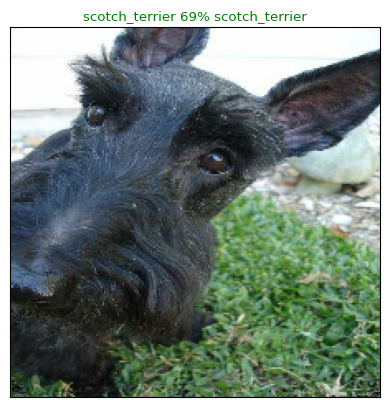

In [121]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 1)

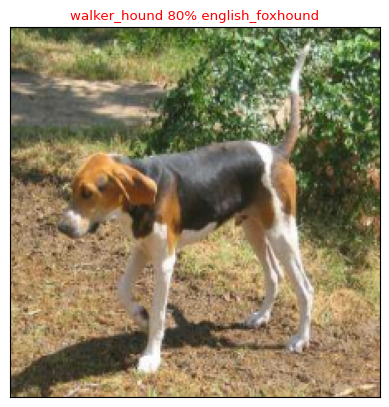

In [122]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 42)

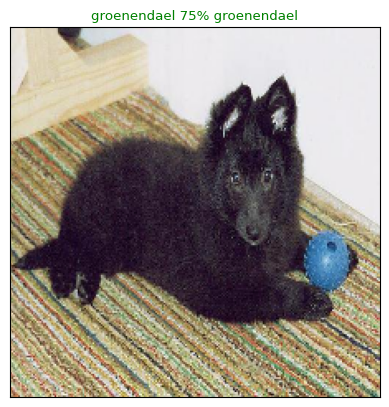

In [123]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 77)

We now have a function to visualize our model's top prediction. We'll build another one to visualize our model's top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
    * Prediction probabilities indexes ✅
    * Prediction probabilities values ✅
    * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [192]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
    """
    Plot the top 10 highest prediction confidences along with the truth label for sample n.
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label and ground truth label
    pred_label = get_pred_label(pred_prob)
    ground_truth_label = get_pred_label(true_label)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values,
                       color = 'grey')
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels = top_10_pred_labels,
               rotation = 'vertical')

    # Change color of true label
    if np.isin(ground_truth_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == ground_truth_label)].set_color('green')
    else:
        pass

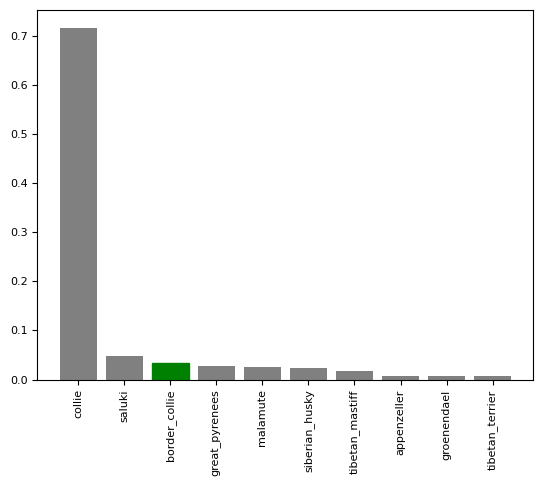

In [193]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 9)

With the previous functions to help us visualize our predictions and evaluate our model, we can now display a few at a time to give a better overview of our model's performance.

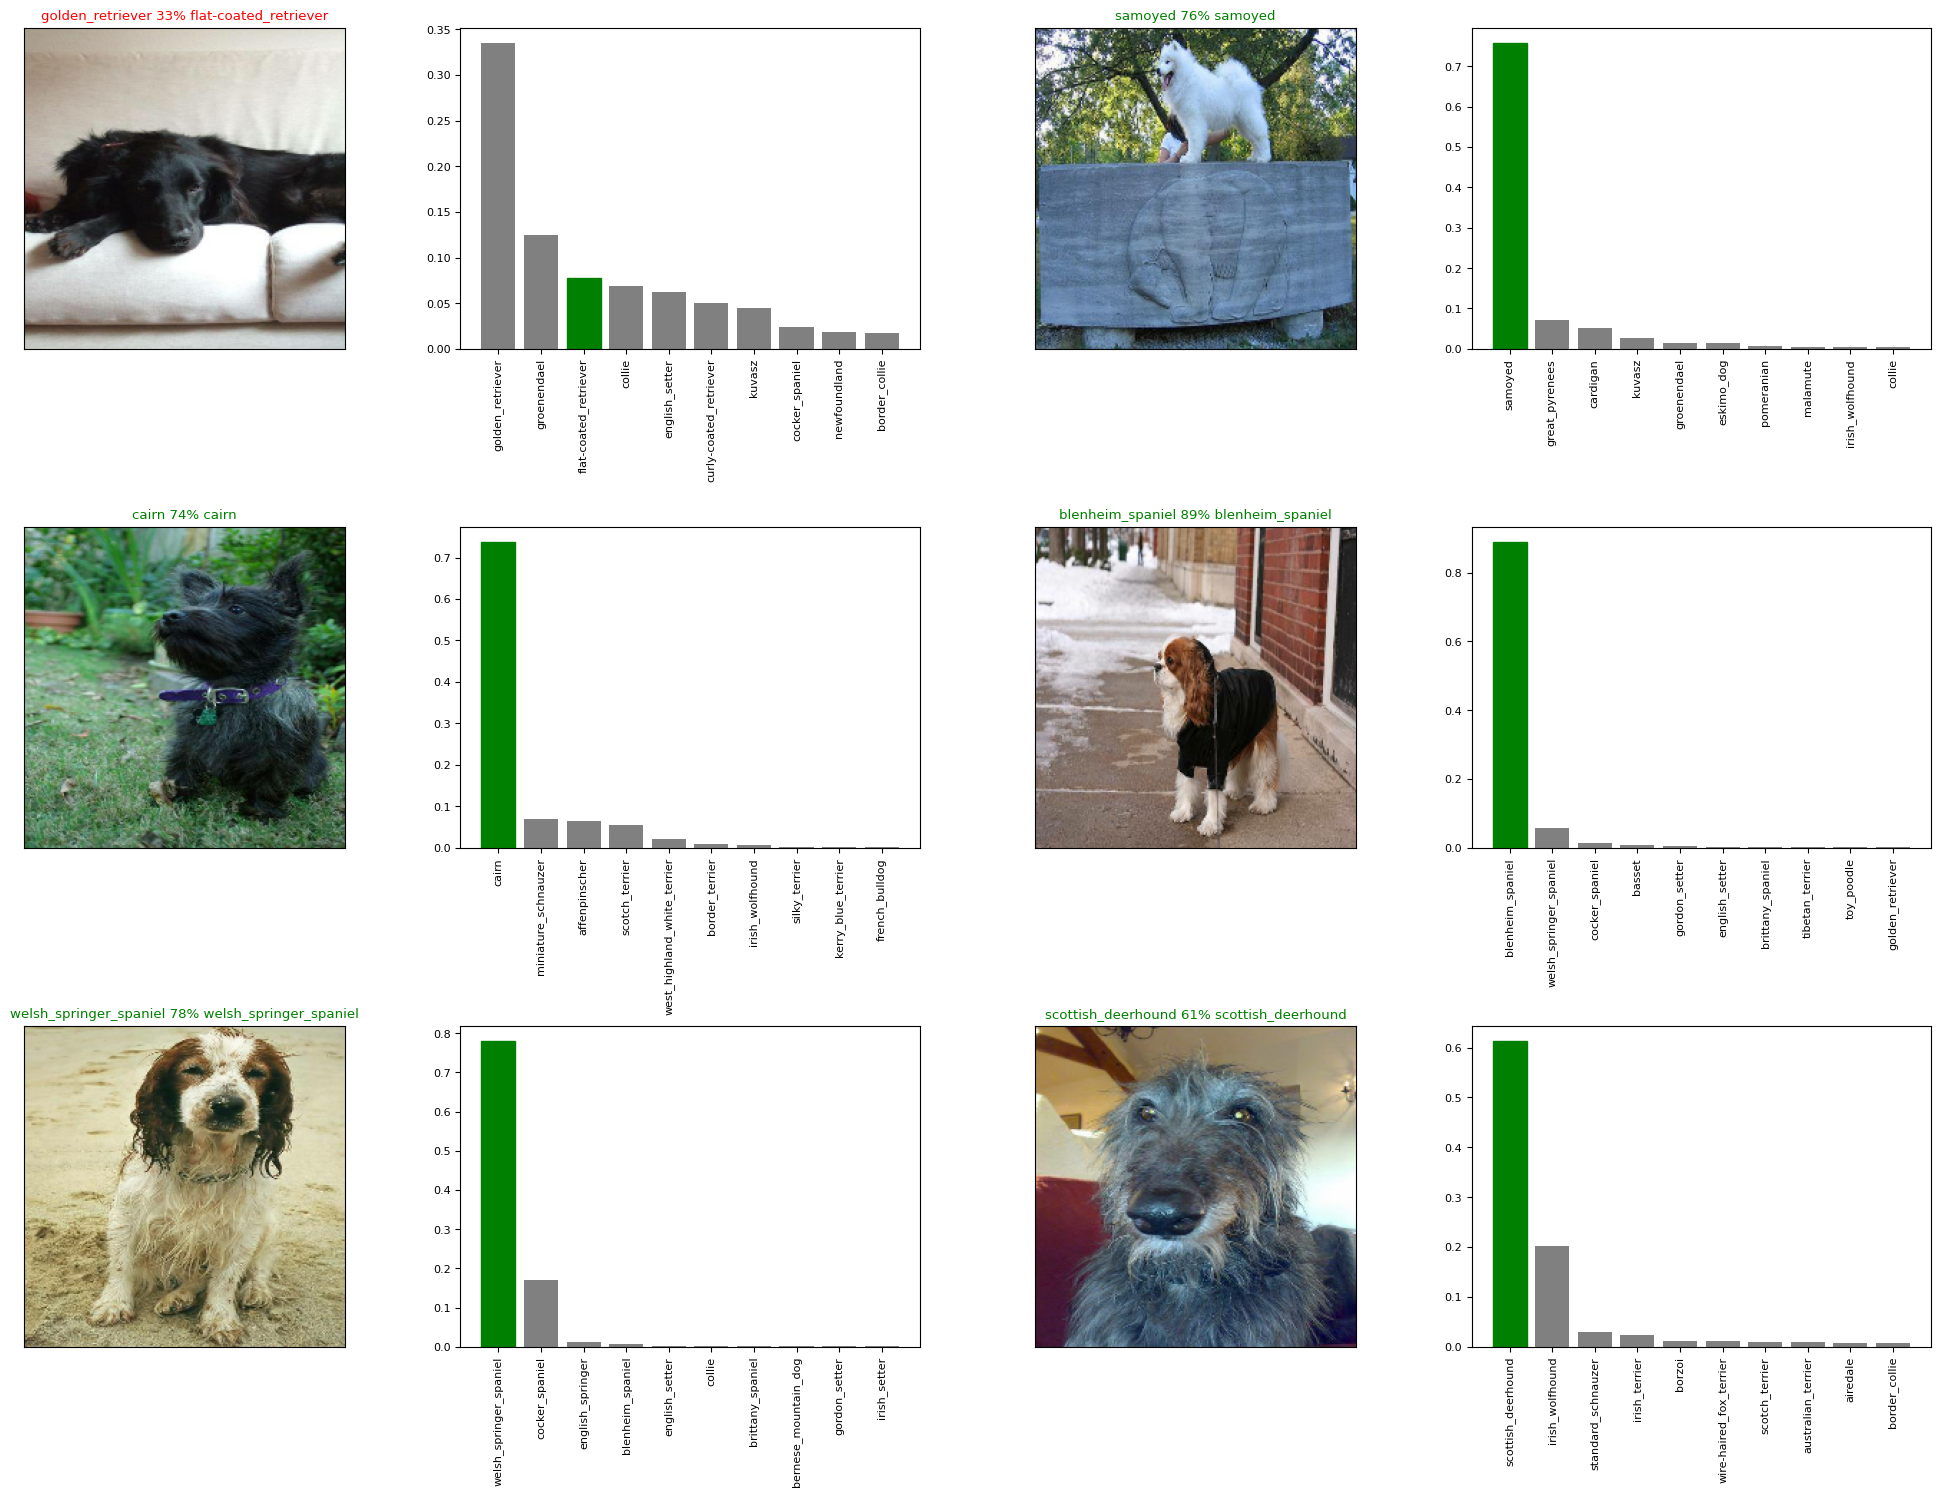

In [201]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize = (10 * num_cols, 5 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities = predictions,
              labels = val_labels,
              images = val_images,
              n = i + i_multiplier)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_pred_conf(prediction_probabilities = predictions,
                   labels = val_labels,
                   n = i + i_multiplier)

plt.tight_layout(h_pad = 1.0)
plt.show()

**Challenge:** Create a confusion matrix with the model's predictions and true labels

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [299]:
# Create a function that creates a confusion matrix from predictions and val_labels

def conf_matrix(predictions, true_labels, unique_breeds, n):
    """
    Creates a confusion matrix out of the n first predictions and val_labels provided as inputs.
    """

    y_pred = []
    y_true = []
    c_m_labels = []
    

    for i in range(n):
        y_pred.append(get_pred_label(predictions[i]))
        y_true.append(get_pred_label(true_labels[i]))

    c_m = confusion_matrix(y_true, y_pred, labels = y_true)

    plt.rcParams['figure.figsize'] = (10.0, 9.0)
    plt.rcParams['font.size'] = 10

    display_c_m = ConfusionMatrixDisplay(c_m, display_labels = y_true)
    display_c_m.plot(cmap = 'Blues', xticks_rotation = 25)

    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.title('Dog breed confusion matrix', fontsize = 24)

    plt.show()

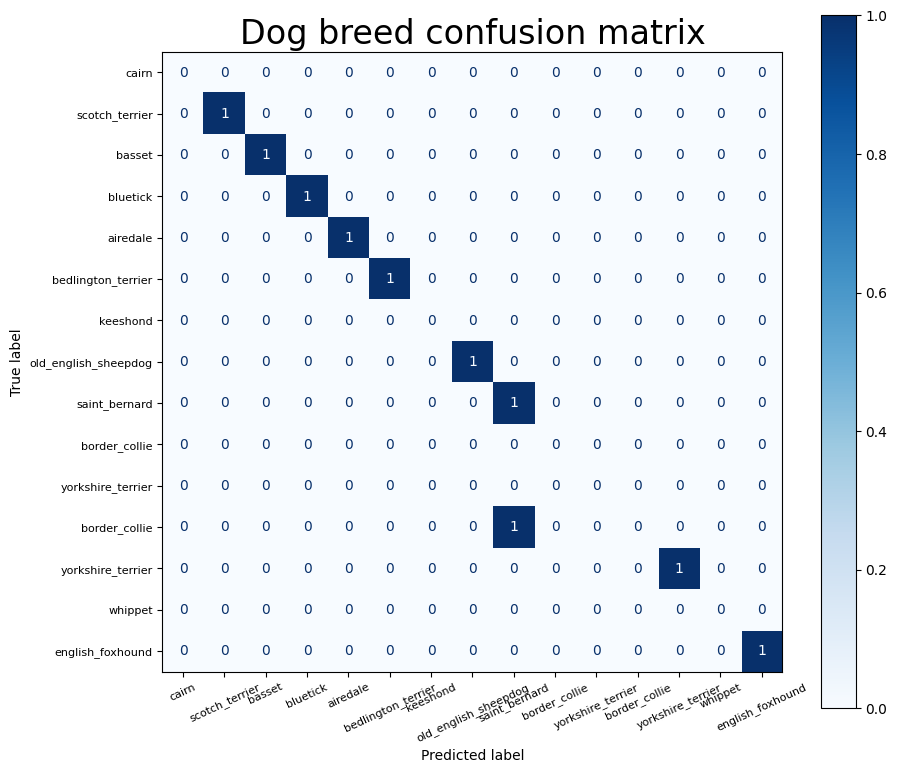

In [302]:
conf_matrix(predictions = predictions, true_labels = val_labels, unique_breeds = unique_breeds, n = 15)

## Saving and reloading a trained model

In [70]:
# Create a function to save a model
def save_model(model, suffix = None):
    """
    Saves a given model in the models directory and appends a suffix (string).
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join('data/dog-breed-identification/models',
                            datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
    model_path = modeldir + '-' + suffix + '.keras' # the format of the model is .keras
    print(f'Saving model to: {model_path}...')
    model.save(model_path)
    return model_path

In [58]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f'Loading saved model from: {model_path}...')
    model = tf.keras.models.load_model(model_path,
                                       custom_objects = {'KerasLayer': hub.KerasLayer})
    return model

Let's make sure our save and load functions work properly...

In [217]:
# Save our model trained on 1000 images
save_model(model, suffix = '1000-images-mobilenetv2-Adam')

Saving model to: data/dog-breed-identification/models/20250606-21461749260767-1000-images-mobilenetv2-Adam.keras...


'data/dog-breed-identification/models/20250606-21461749260767-1000-images-mobilenetv2-Adam.keras'

In [218]:
# Load a trained model
loaded_1000_image_model = load_model('data/dog-breed-identification/models/20250606-21461749260767-1000-images-mobilenetv2-Adam.keras')

Loading saved model from: data/dog-breed-identification/models/20250606-21461749260767-1000-images-mobilenetv2-Adam.keras...


In [219]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 59ms/step - loss: 1.3109 - accuracy: 0.6700


[1.310867428779602, 0.6700000166893005]

In [220]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 75ms/step - loss: 1.3109 - accuracy: 0.6700


[1.310867428779602, 0.6700000166893005]

## Training the model on the complete dataset 🦮

In [303]:
len(X), len(y)

(10222, 10222)

In [304]:
X[:10]

['data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [306]:
X_train[:10]

['data/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
 'data/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 'data/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
 'data/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
 'data/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg',
 'data/dog-breed-identification/train/0ea5759640f2e1c2d1a06adaf8a54ca7.jpg',
 'data/dog-breed-identification/train/03e1d2ee5fd90aef036c90a9e7f81177.jpg',
 'data/dog-breed-identification/train/16941a6728ddb9cb7423a6cc97fbe071.jpg',
 'data/dog-breed-identification/train/0bedbecd92390ef9f4f7c8b06a629340.jpg',
 'data/dog-breed-identification/train/143b9484273e57668d03bfc26755810a.jpg']

In [307]:
len(X_train)

800

In [308]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [309]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [310]:
# Create a model based on full dataset
full_model = create_model()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2


In [311]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# There is no validation set when training on all the data. We can't monitor validation accuracy.
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                             patience = 3)

**Note:** Running the cell below will take much longer (~ 30 minutes for the first epoch) because the GPU has to load all of the images into memory.

In [312]:
# Fit the full model to the full dataset
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 23s 68ms/step - loss: 1.3510 - accuracy: 0.6653
Epoch 2/100
320/320 [==============================] - 22s 68ms/step - loss: 0.3965 - accuracy: 0.8841
Epoch 3/100
320/320 [==============================] - 22s 68ms/step - loss: 0.2349 - accuracy: 0.9339
Epoch 4/100
320/320 [==============================] - 22s 68ms/step - loss: 0.1521 - accuracy: 0.9648
Epoch 5/100
320/320 [==============================] - 21s 67ms/step - loss: 0.1051 - accuracy: 0.9786
Epoch 6/100
320/320 [==============================] - 22s 67ms/step - loss: 0.0770 - accuracy: 0.9869
Epoch 7/100
320/320 [==============================] - 22s 67ms/step - loss: 0.0583 - accuracy: 0.9912
Epoch 8/100
320/320 [==============================] - 22s 68ms/step - loss: 0.0461 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 22s 68ms/step - loss: 0.0385 - accuracy: 0.9954
Epoch 10/100
320/320 [==============================] - 22s 68ms/step - l

In [315]:
save_model(full_model, suffix = 'full-image-set-mobilenetv2-Adam')

Saving model to: data/dog-breed-identification/models/20250607-22571749351456-full-image-set-mobilenetv2-Adam.keras...


'data/dog-breed-identification/models/20250607-22571749351456-full-image-set-mobilenetv2-Adam.keras'

In [59]:
# Load the saved full model
loaded_full_model = load_model('data/dog-breed-identification/models/20250607-22571749351456-full-image-set-mobilenetv2-Adam.keras')

Loading saved model from: data/dog-breed-identification/models/20250607-22571749351456-full-image-set-mobilenetv2-Adam.keras...


## Making predictions on the test dataset

Given that our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we need the test data in the same format.

We can do this with `create_data_batches()` that we created earlier. This function takes a list of paths and filenames as input and converts them into Tensor batches.

To make predictions on the test data:
* Get the test image filenames ✅
* Convert the filenames into test data batches using `create_data_batches()` and set the `test_data` parameter to `True` (the test data doesn't have labels!) ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model ✅

In [41]:
# Load test image filenames
test_path = 'data/dog-breed-identification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/dog-breed-identification/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'data/dog-breed-identification/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'data/dog-breed-identification/test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'data/dog-breed-identification/test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'data/dog-breed-identification/test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'data/dog-breed-identification/test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'data/dog-breed-identification/test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'data/dog-breed-identification/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data/dog-breed-identification/test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'data/dog-breed-identification/test/cb120c57904e8c0694bbe259c58a873c.jpg']

In [42]:
len(test_filenames)

10357

In [325]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [326]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model and processing all the test images data batches will take a long time to run.

In [327]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose = 1)

324/324 [==============================] - 21s 65ms/step


In [328]:
# Save predictions (NumPy array) to csv file (to access later)
np.savetxt('data/dog-breed-identification/preds_array.csv', test_predictions, delimiter = ',')

In [49]:
# Load predictions (NumPy array) from csv file
loaded_test_predictions = np.loadtxt('data/dog-breed-identification/preds_array.csv', delimiter = ',')

In [50]:
loaded_test_predictions[:10]

array([[1.14692178e-09, 6.05752393e-06, 8.73716655e-09, ...,
        6.96517600e-06, 2.18637247e-10, 1.90539824e-11],
       [1.38823492e-02, 9.71204543e-04, 2.30630612e-05, ...,
        8.67414747e-06, 1.41755868e-06, 1.16642944e-07],
       [6.05429449e-08, 1.62479100e-10, 2.18273880e-12, ...,
        1.20869035e-11, 4.39732755e-12, 2.23116642e-12],
       ...,
       [2.53976874e-12, 5.96596834e-08, 2.80735502e-09, ...,
        9.58277269e-07, 2.44165781e-11, 3.71390592e-11],
       [1.29569386e-07, 1.54277208e-04, 3.66567665e-09, ...,
        5.96148775e-09, 4.86043877e-13, 2.82838264e-09],
       [6.24047587e-08, 1.38539114e-09, 8.52992699e-09, ...,
        1.16147636e-09, 1.02062012e-08, 9.81951143e-06]])

In [51]:
loaded_test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

The Kaggle sample submission example for this project requires our model's prediction probabilities to be presented in a DataFrame with an ID column and columns of probabilities for each different dog breed ([see Kaggle dog breed identification project documentation](https://www.kaggle.com/competitions/dog-breed-identification/overview)).

To organize our data in this format:
* Create a Pandas DataFrame with an ID column and prediction probability columns for each dog breed ✅
* Add the data to the ID column by extracting the test image IDs from their filepaths ✅
* Add prediction probabilities to each of the dog breed columns ✅
* Export the DataFrame as a CSV file to submit it to Kaggle ✅

In [37]:
list(unique_breeds)

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [38]:
['id'] + list(unique_breeds)

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [39]:
# Create a Pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns = ['id'] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [43]:
test_filenames

['data/dog-breed-identification/test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'data/dog-breed-identification/test/dae9fd18836d8df20989ef0101771d4b.jpg',
 'data/dog-breed-identification/test/079a40f22b0fad9a66f76797b62bb930.jpg',
 'data/dog-breed-identification/test/ab8462f9a501d362041d47582fddc9ad.jpg',
 'data/dog-breed-identification/test/8895089b432e020cc42e6262b5a1c2dd.jpg',
 'data/dog-breed-identification/test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 'data/dog-breed-identification/test/77c1ab99cffb817d54fb14f229aeb118.jpg',
 'data/dog-breed-identification/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data/dog-breed-identification/test/d61a09cecf56666cdb315ebce4b93c43.jpg',
 'data/dog-breed-identification/test/cb120c57904e8c0694bbe259c58a873c.jpg',
 'data/dog-breed-identification/test/10863e6d9d1cb526cc9d90f30a585719.jpg',
 'data/dog-breed-identification/test/43cb5f3a505d710bd16e0a0d583a781b.jpg',
 'data/dog-breed-identification/test/a5aa4e972242a61829ad10b220a12c64.jpg',
 'data/dog-b

In [47]:
# Removing the path string from filenames at a given path
os.listdir(test_path)

['266490a2b053a4a3bf68e779f28fb5a9.jpg',
 'dae9fd18836d8df20989ef0101771d4b.jpg',
 '079a40f22b0fad9a66f76797b62bb930.jpg',
 'ab8462f9a501d362041d47582fddc9ad.jpg',
 '8895089b432e020cc42e6262b5a1c2dd.jpg',
 '985ae7fc271ac4a0d131e546c0f95bb6.jpg',
 '77c1ab99cffb817d54fb14f229aeb118.jpg',
 'ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'd61a09cecf56666cdb315ebce4b93c43.jpg',
 'cb120c57904e8c0694bbe259c58a873c.jpg',
 '10863e6d9d1cb526cc9d90f30a585719.jpg',
 '43cb5f3a505d710bd16e0a0d583a781b.jpg',
 'a5aa4e972242a61829ad10b220a12c64.jpg',
 'abca35eb197f260e4e348156818bf930.jpg',
 '28950f53443e40e5a704a8cb5a1e1d35.jpg',
 '326e3c2a0a47f79ad1a87ca5c2f84d79.jpg',
 '727fb62505f8fc165a40f755c94e36dd.jpg',
 'bccec86223be760e4a9c7899d0628812.jpg',
 '42feb15909b1a7da5d85bc1a2baafe47.jpg',
 'b8da90f454f62fb33c83715a404aca3b.jpg',
 'd38cfa7f70adf71a5c7281f64218034d.jpg',
 'b8a3047509bdd743df820c7a6cd7dd87.jpg',
 '291c193c35def70cb8b9e4371b1f9b3c.jpg',
 'fc50b817f059dbfff5fa1857d7769cc2.jpg',
 'a6faea5f33b025

In [54]:
# Separating the root of a filename from its extension
os.path.splitext(test_filenames[0])

('data/dog-breed-identification/test/266490a2b053a4a3bf68e779f28fb5a9', '.jpg')

In [55]:
# Create a list of test image IDs for our predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids

['266490a2b053a4a3bf68e779f28fb5a9',
 'dae9fd18836d8df20989ef0101771d4b',
 '079a40f22b0fad9a66f76797b62bb930',
 'ab8462f9a501d362041d47582fddc9ad',
 '8895089b432e020cc42e6262b5a1c2dd',
 '985ae7fc271ac4a0d131e546c0f95bb6',
 '77c1ab99cffb817d54fb14f229aeb118',
 'ad7e50abca9b7c6a88b63946c5bbe493',
 'd61a09cecf56666cdb315ebce4b93c43',
 'cb120c57904e8c0694bbe259c58a873c',
 '10863e6d9d1cb526cc9d90f30a585719',
 '43cb5f3a505d710bd16e0a0d583a781b',
 'a5aa4e972242a61829ad10b220a12c64',
 'abca35eb197f260e4e348156818bf930',
 '28950f53443e40e5a704a8cb5a1e1d35',
 '326e3c2a0a47f79ad1a87ca5c2f84d79',
 '727fb62505f8fc165a40f755c94e36dd',
 'bccec86223be760e4a9c7899d0628812',
 '42feb15909b1a7da5d85bc1a2baafe47',
 'b8da90f454f62fb33c83715a404aca3b',
 'd38cfa7f70adf71a5c7281f64218034d',
 'b8a3047509bdd743df820c7a6cd7dd87',
 '291c193c35def70cb8b9e4371b1f9b3c',
 'fc50b817f059dbfff5fa1857d7769cc2',
 'a6faea5f33b025272df4f3d8dde780d7',
 '32d1d7ac227098b3f964705d5f651236',
 '078a52db2d156257696c771487a6a316',
 

In [50]:
# Add test_ids to our Pandas DataFrame
preds_df['id'] = test_ids

In [51]:
preds_df.head()

id affenpinscher afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9           NaN          NaN   
1  dae9fd18836d8df20989ef0101771d4b           NaN          NaN   
2  079a40f22b0fad9a66f76797b62bb930           NaN          NaN   
3  ab8462f9a501d362041d47582fddc9ad           NaN          NaN   
4  8895089b432e020cc42e6262b5a1c2dd           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [52]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = loaded_test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9   1.146922e-09  6.057524e-06   
1  dae9fd18836d8df20989ef0101771d4b   1.388235e-02  9.712045e-04   
2  079a40f22b0fad9a66f76797b62bb930   6.054294e-08  1.624791e-10   
3  ab8462f9a501d362041d47582fddc9ad   4.371900e-10  3.622577e-08   
4  8895089b432e020cc42e6262b5a1c2dd   7.283364e-10  1.379490e-09   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         8.737167e-09  9.957427e-07                    5.079170e-12   
1         2.306306e-05  2.635970e-07                    2.051138e-07   
2         2.182739e-12  3.535547e-10                    5.837317e-11   
3         1.770336e-11  1.640159e-08                    3.249018e-11   
4         1.981109e-08  5.247289e-11                    1.054960e-08   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  3.164825e-06        3.110851e-12  1.464514e-10  3.005528e-03  ...   
1  2.028557e-07        4.990105e-03  1.067769e-08  1.299681e-07  ...   
2  1.973160e-11        1.002841e-11  6.221781e-12  7.553742e-12  ...   
3  2.673471e-08        4.175774e-09  8.547716e-12  8.954266e-10  ...   
4  2.201920e-08        9.072050e-08  2.981443e-04  1.242847e-05  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.990853e-09  6.418906e-09  4.585943e-05  1.686037e-06  7.205664e-07   
1  3.525178e-07  3.196944e-06  3.436497e-07  4.860865e-05  6.222924e-05   
2  3.467741e-12  2.303506e-12  2.053597e-12  1.135451e-10  7.939878e-11   
3  2.482100e-09  2.922045e-10  2.750190e-10  1.848714e-08  1.500873e-10   
4  3.821804e-09  8.770130e-08  2.279206e-09  1.569368e-10  1.142523e-09   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            6.977594e-12                 3.395456e-08  6.965176e-06   
1            3.407526e-10                 1.378747e-05  8.674147e-06   
2            4.425970e-12                 3.418292e-12  1.208690e-11   
3            3.029572e-08                 2.074624e-09  2.989600e-10   
4            7.625414e-08                 1.277735e-07  1.756213e-07   

   wire-haired_fox_terrier  yorkshire_terrier  
0             2.186372e-10       1.905398e-11  
1             1.417559e-06       1.166429e-07  
2             4.397328e-12       2.231166e-12  
3             9.090626e-14       2.531699e-07  
4             6.004294e-08       6.966341e-11  

[5 rows x 121 columns]

In [53]:
# Export and save our dataframe in a CSV file
preds_df.to_csv('data/dog-breed-identification/full_model_predictions_submission_1_mobilenetv2.csv',
                index = False)

## Making predictions on custom images

Setting up for predictions on our dog photos:
* Get the filepath of our dog photos
* Turn the filepaths and filenames into data batches using `create_data_batches` (our custom images don't have labels and we set the `test_data` parameter to `True`)
* Pass the custom image data batch to our model's `predict()` method
* Convert the prediction probability outputs to prediction labels
* Compare the predicted labels to the custom images

In [52]:
# Get custom image filepaths and filenames
custom_path = 'data/dog-breed-identification/custom_dog_photos/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path) if not fname.startswith('.')]

In [53]:
custom_image_paths

['data/dog-breed-identification/custom_dog_photos/dog_photo_1.jpeg',
 'data/dog-breed-identification/custom_dog_photos/dog_photo_3.jpeg',
 'data/dog-breed-identification/custom_dog_photos/dog_photo_2.jpeg',
 'data/dog-breed-identification/custom_dog_photos/dog_photo_4.jpeg']

In [55]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [60]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

2025-06-10 15:07:01.858448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 445ms/step


In [61]:
custom_preds.shape

(4, 120)

In [62]:
# Turn prediction probabilities into their respective label (easier to understand) - copied from above for convenience
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

In [63]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chesapeake_bay_retriever',
 'golden_retriever',
 'staffordshire_bullterrier',
 'airedale']

In [65]:
# Get custom images (unbatchify - our previous unbatchify() function doesn't work because we don't have labels)
custom_images = []

# Loop through batched data to unbatch it
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

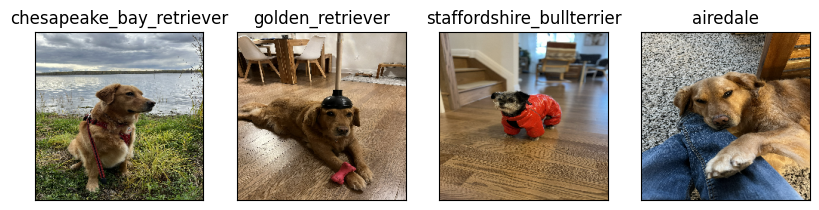

In [66]:
# Check custom image predictions
plt.figure(figsize = (10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)

![unstructured-data-tesnorflow-workflow.png](data/dog-breed-identification/jupyter_nb_images/unstructured-data-tesnorflow-workflow.png)